### Описание и цели проекта

Наша цель - предсказание стоимости автомобиля в оперативном режиме. В нашем распоряжении датасет с описанием автомобилей, их техническими характеристиками и ценами.

Критериями оценки качества модели будут RMSE и время предсказания. В качестве дополнитель критерия было упомянута скорость обучения модели, но исходя из описания работы, мы моджем предположить, что этот параметр менее приоритетен, при условии, что обучение не требует совсем неприемлемых затрат времени.

Для решения этой задачи мы будем использовать как линейные модели (предположительно, более быстрые), так и градиентный бустинг (предположительно, наиболее точная модель).


### Импорт библиотек

In [1]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, PoissonRegressor
from sklearn.preprocessing import OrdinalEncoder



### Загрузка данных


Данные представляют собой датасет с описанием автомобилей, их техническими характеристиками и ценами и содержаться в одном файле autos.csv

In [2]:
df = pd.read_csv('/Users/germanchernukhin/Documents/GitHub/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Описание данных


Посмотрим на описательные статистики, пропуски и дубликаты

In [3]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(4)

В датасете присутствуют пропуски в некоторых колонках, дубликаты и выбросы в некоторых признаках
Дубликатов всего 4, поэтому их можно удалить

In [6]:
df = df.drop_duplicates()

Визуализируем пропуски

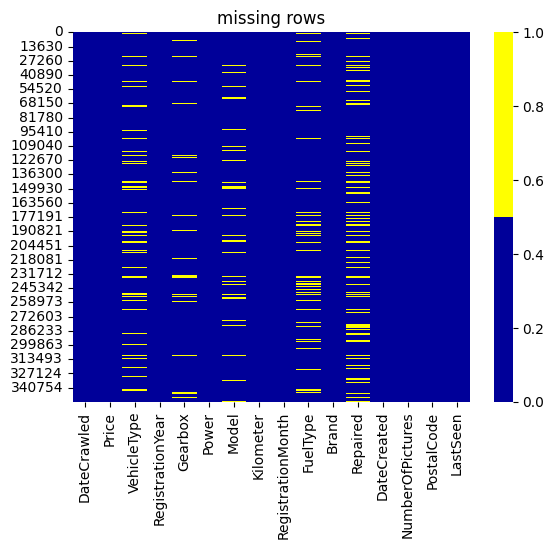

In [7]:
cols = df.columns[:20]
colours = ['#000099', '#ffff00'] 
plt.title('missing rows')
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

Проверим количество уникальных значений в каждой колонке

In [8]:
unique_counts = df.nunique()
print(unique_counts)

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64


Number of pictures можно убрать, там везде 0 и нет пропусков

In [9]:
df = df.drop(columns=['NumberOfPictures'])

### Предобработка данных

Для начала, попробуем максимально заполнить пропуски

Попробуем сначала найти пропуски в моделях и заполнить их в зависимости от бренда и мощности, в которых пропусков нет. В чем-то мы, возможно, ошибемся, но модель - это вероятно ключевой признак для определения стоимости автомобиля.

In [10]:
def safe_mode(x):
    mode = x.mode()
    return mode.iloc[0] if not mode.empty else pd.NA
most_frequent_model = df.groupby(['Brand','Power'])['Model'].transform(safe_mode)

df['Model'] = df['Model'].fillna(most_frequent_model)

После этого попробуем заполнить пропуски в типах автомобилей в зависимости от модели

In [11]:
most_frequent_type = df.groupby('Model')['VehicleType'].transform(safe_mode)
df['VehicleType'] = df['VehicleType'].fillna(most_frequent_type)

Посмотрим, сколько строк мы потеряем, удалив пропуски в моделях


In [12]:
df['Model'].count()/df['DateCrawled'].count()

np.float64(0.9899143538442002)

In [13]:
df = df.dropna(subset='Model')

Мы потеряли 1% от всего датасета, для такого важного признака это приемлемо

Теперь попробуем заполнить пропуски в типе топлива в зависимости от модели и мощности

In [14]:
most_frequent_fuel = df.groupby(['Model','Power'])['FuelType'].transform(safe_mode)
df['FuelType'] = df['FuelType'].fillna(most_frequent_fuel)

In [15]:
df['FuelType'].count()/df['DateCrawled'].count()

np.float64(0.998799855184426)

In [16]:
df = df.dropna(subset='FuelType')

Получилось заполнить почти всё, без слишком больших потерь. К сожалению, с Gearbox так сделать, вероятно, не получится. Тип коробки передач - это важный признак, который может сильно влиять на цену и не обязательно связан с мощностью автомобиля 

In [17]:
df.loc[df['FuelType'] == 'electric', 'Gearbox'] = 'auto'
df['Gearbox'].value_counts()

Gearbox
manual    266559
auto       65142
Name: count, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350370 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        350370 non-null  object
 1   Price              350370 non-null  int64 
 2   VehicleType        350370 non-null  object
 3   RegistrationYear   350370 non-null  int64 
 4   Gearbox            331701 non-null  object
 5   Power              350370 non-null  int64 
 6   Model              350370 non-null  object
 7   Kilometer          350370 non-null  int64 
 8   RegistrationMonth  350370 non-null  int64 
 9   FuelType           350370 non-null  object
 10  Brand              350370 non-null  object
 11  Repaired           280782 non-null  object
 12  DateCreated        350370 non-null  object
 13  PostalCode         350370 non-null  int64 
 14  LastSeen           350370 non-null  object
dtypes: int64(6), object(9)
memory usage: 42.8+ MB


Пропуски в Repaired, FuelType и Gearbox заполним словом unknown, тут мы не знаем причину не предоставления информации и не можем сделать предположение. 

In [19]:
df = df.fillna('unknown')


Так как у нас цель - предсказание цены автомобиля в оперативном режиме, колонки DateCrawled и LastSeen нам не нужны. Уберем их. Date created оставим, но разобьём на год и месяц, так как это связано с инфляцией и сезонностью

In [20]:
df = df.drop(columns=['DateCrawled', 'LastSeen'])

In [21]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['YearCreated'] = df['DateCreated'].dt.year
df['MonthCreated'] = df['DateCreated'].dt.month
df = df.drop(columns=['DateCreated'])


Проверим распределение года регистрации автомобиля

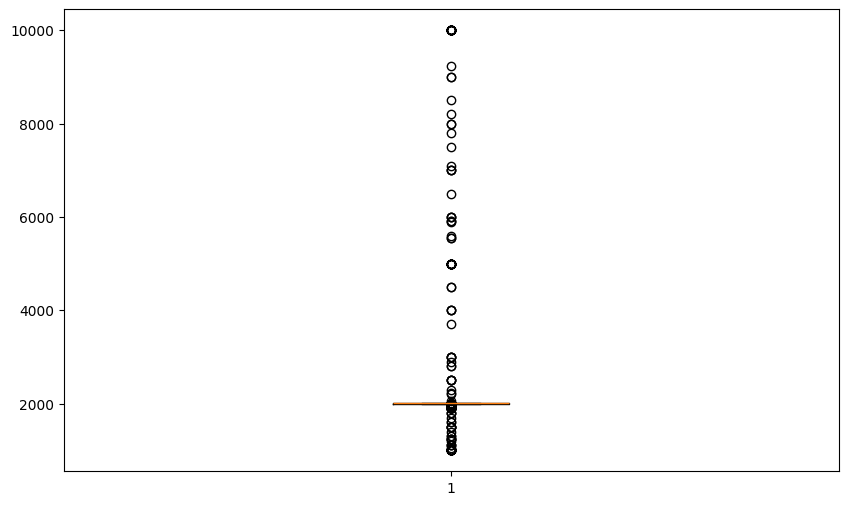

In [22]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.boxplot(df['RegistrationYear'])
plt.show()

Предположим, что допустимый диапазон года регистрации автомобиля 1980-2024


In [23]:
print(df[df['RegistrationYear'] > 2024]['RegistrationYear'].count()/df['RegistrationYear'].count())
print(df[df['RegistrationYear'] < 1981]['RegistrationYear'].count()/df['RegistrationYear'].count())


0.00023118417672745954
0.009404343979221965


In [24]:
df =df[df['RegistrationYear'] > 1980]
df = df[df['RegistrationYear'] < 2025]

Посмотрим на выбросы мощности

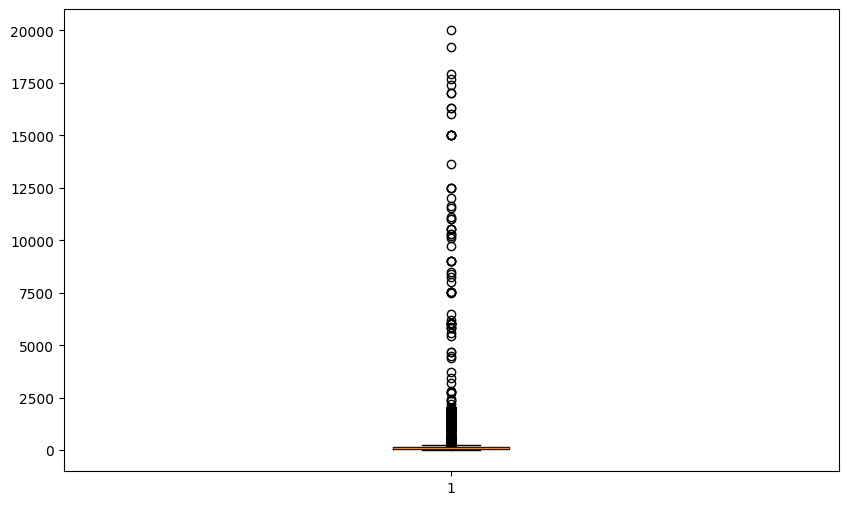

In [25]:
plt.boxplot(df['Power'])
plt.show()

In [26]:
df[df['Power'] > 500]['Power'].count()/df['Power'].count()

np.float64(0.0009423794071367228)

In [27]:
df[df['Power'] < 30]['Power'].count()/df['Power'].count()

np.float64(0.1097655867248425)

Странно, 11% мощностью меньше 30 

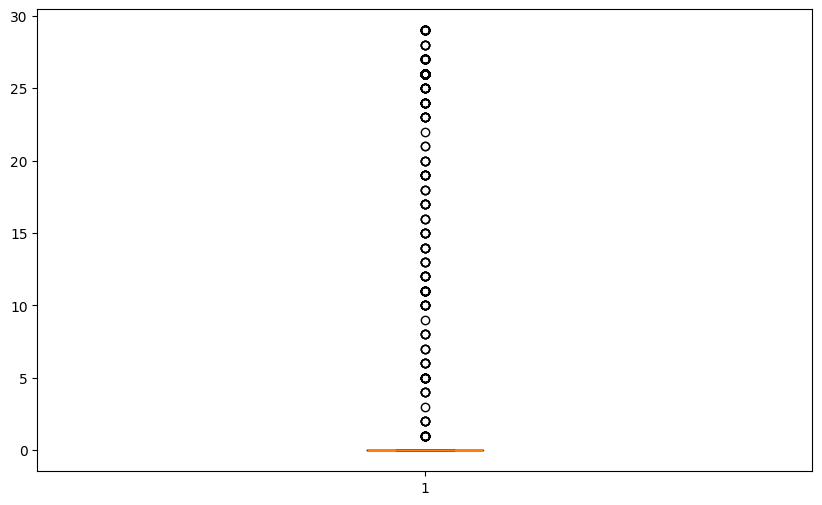

In [28]:
plt.boxplot(df[df['Power'] < 30]['Power'])
plt.show()

In [29]:
df[df['Power'] < 20]['Power'].value_counts().head()


Power
0     37642
1        20
11       18
5        15
19        8
Name: count, dtype: int64

In [30]:
most_frequent_power = df.groupby(['Model'])['Power'].transform(safe_mode)

df.loc[df['Power'] == 0, 'Power'] = most_frequent_power
df = df[df['Power'] > 30]

In [31]:
df['Power'].count()/354369

np.float64(0.9569855150986684)

Всего потеряно 4.3% данных по сравнению с исходным датасетом, что приемлемо

Посмотрим на распределение пробега

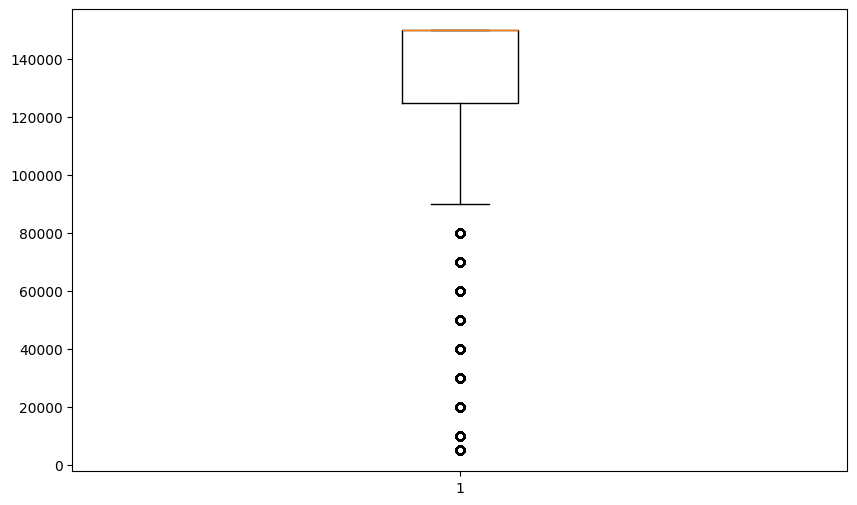

In [32]:
plt.boxplot(df['Kilometer'])
plt.show()

Ничего необычного нет, проверим распределение месяца регистрации

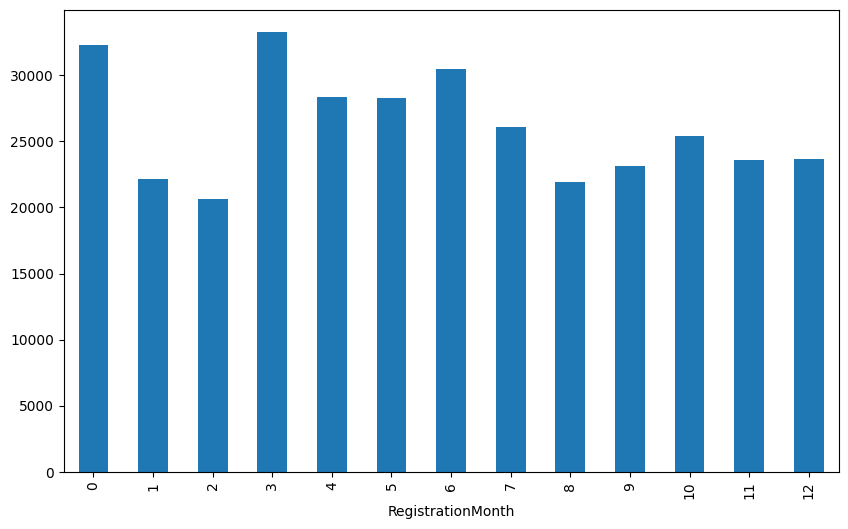

In [33]:

df['RegistrationMonth'].value_counts().sort_index().plot(kind='bar')
plt.show()

Тут похоже 0 месяц - это январь, но тогда часть января это, возможно, февраль и т.д. или месяц просто пропущен. Мы не можем точно определить, как правильно подкорректировать данные, поэтому оставим так


### Визуализация категориальных данных

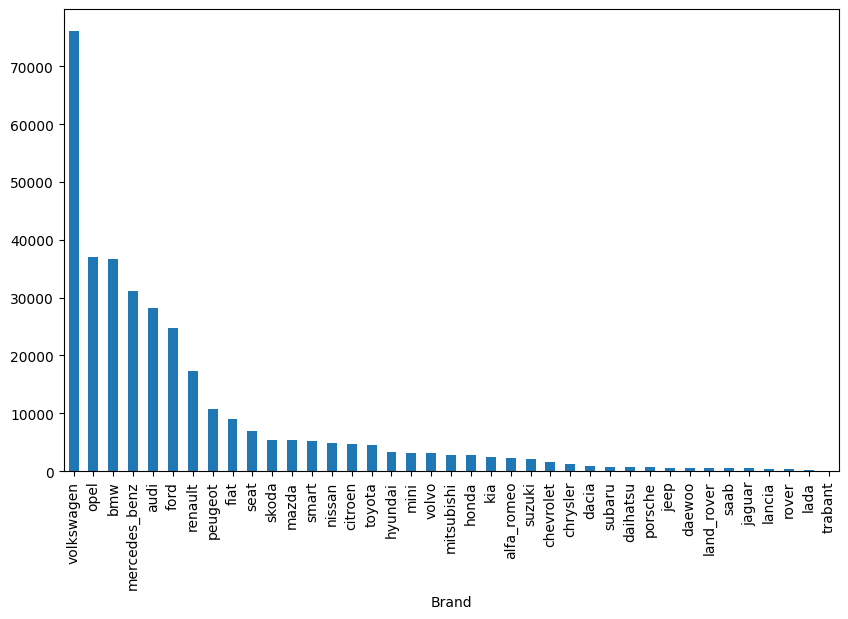

In [34]:
df['Brand'].value_counts()
df['Brand'].value_counts().plot(kind='bar')
plt.show()

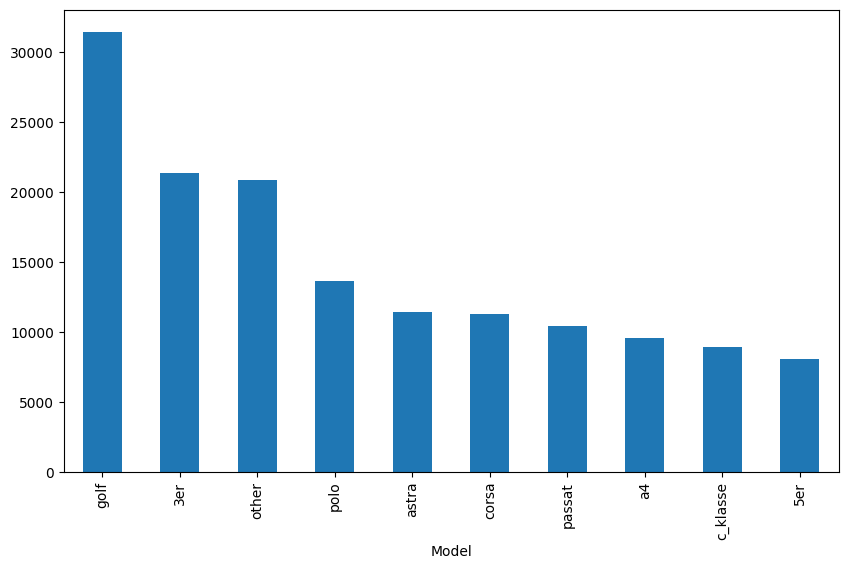

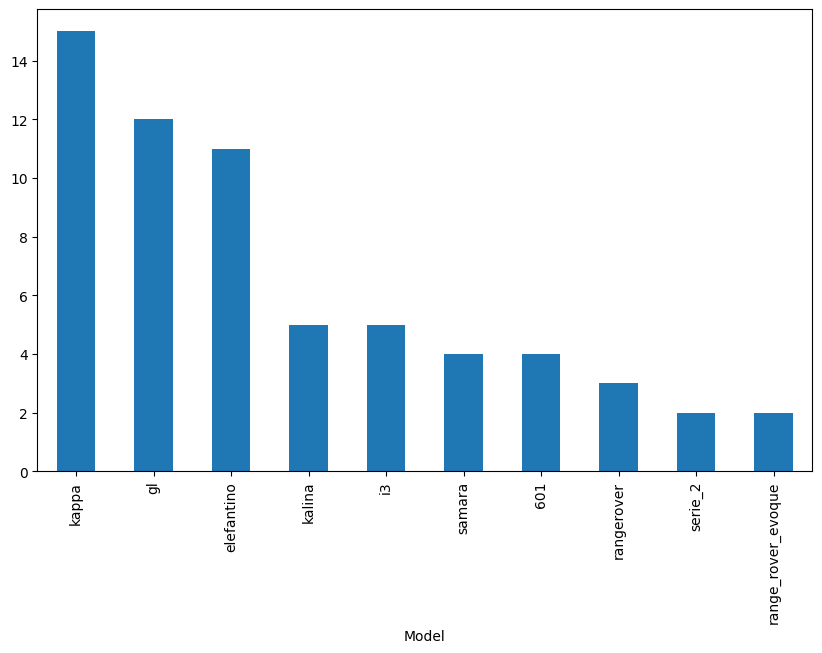

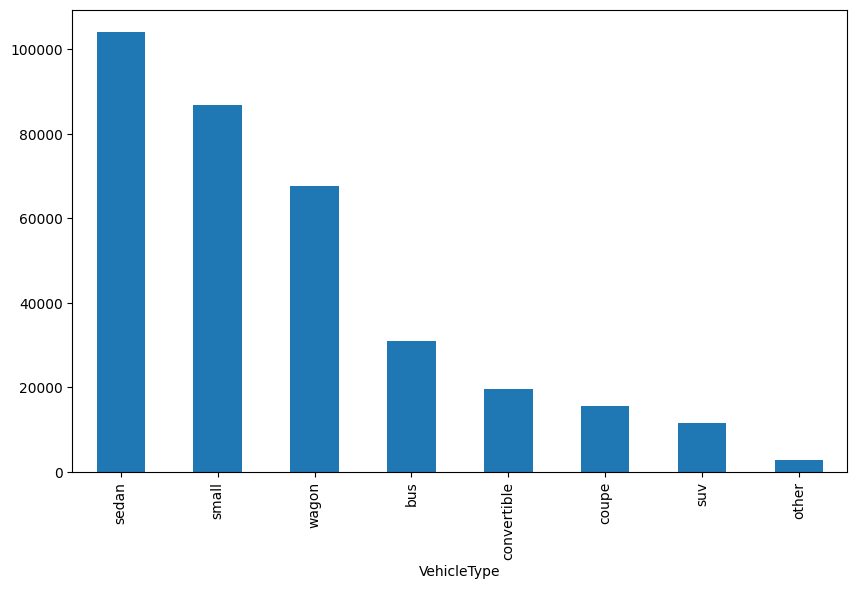

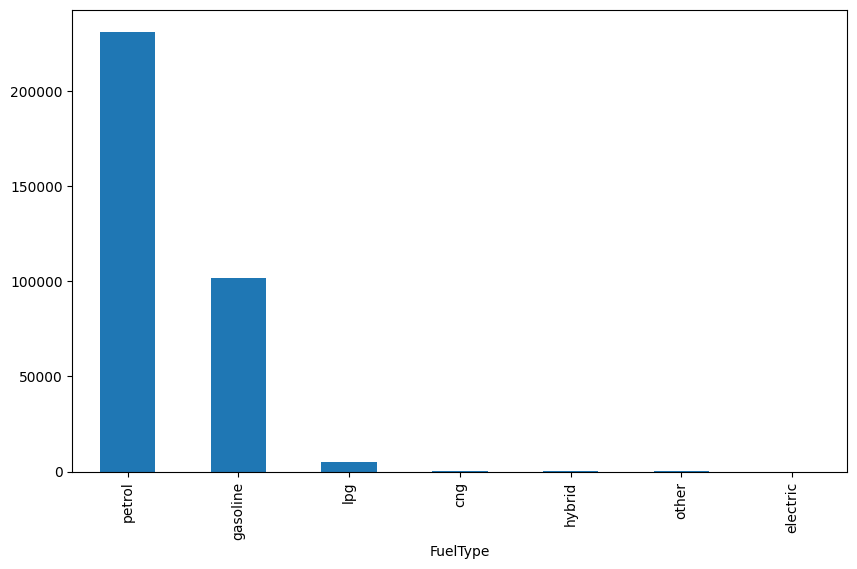

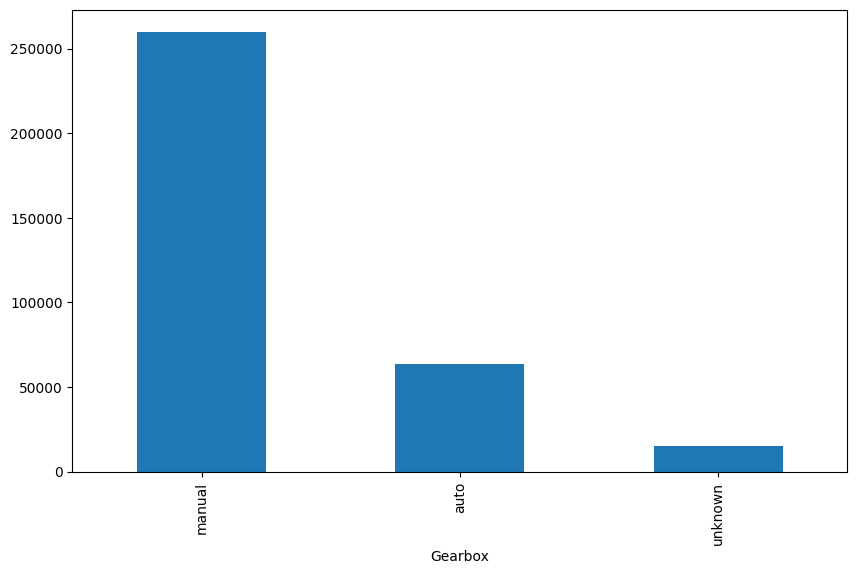

In [35]:
df['Model'].value_counts().head(10).plot(kind='bar')
plt.show()
df['Model'].value_counts().tail(10).plot(kind='bar')
plt.show()
df['VehicleType'].value_counts().plot(kind='bar')
plt.show()
df['FuelType'].value_counts().plot(kind='bar')
plt.show()
df['Gearbox'].value_counts().plot(kind='bar')
plt.show()

У нас есть несколько признаков, в минорных категориях которых нет большого количества данных. Судя по найденной информации lightGBM нативно умеет работать с высоко кардинальными признаками, поэтому попробуем пока оставить всё как есть.

Предобработка завершена, можно начинать обучение модели

### Обучение модели

In [36]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['Price']), df['Price'],
                                                     test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()

In [37]:
num_cols = [col for col in x_train.columns if x_train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in df.columns if df[col].dtype == 'object']

In [38]:
%%time
model.fit(x_train[num_cols], y_train)
time_start = time.time()
rmse = np.sqrt(mean_squared_error(y_test, model.predict(x_test[num_cols])))
time_end = time.time()
time_total = time_end - time_start
time_avg = time_total / len(x_test)
print(f"RMSE LightGBM: {rmse:.1f}")
print(f"Суммарное время предсказания: {time_total:.4f} секунд")
print(f"Среднее время предсказания на одну строку: {time_avg:.8f} секунд")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 271300, number of used features: 5
[LightGBM] [Info] Start training from score 4462.499856
RMSE LightGBM: 2114.5
Суммарное время предсказания: 0.0372 секунд
Среднее время предсказания на одну строку: 0.00000055 секунд
CPU times: user 1.12 s, sys: 889 ms, total: 2 s
Wall time: 646 ms


In [39]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Почти ничего не сделав с моделью и используя только числовые признаки, RMSE уже 2110 неплохо. Попробуем использовать линейную регрессию

In [40]:
%%time
model_linear = LinearRegression()
model_linear.fit(x_train[num_cols], y_train)
time_start = time.time()
rmse_linear = np.sqrt(mean_squared_error(y_test, model_linear.predict(x_test[num_cols])))   
time_end = time.time()
time_total = time_end - time_start
time_avg = time_total / len(x_test)
rmse_linear
time_total
time_avg
print(f"RMSE Linear Regression: {rmse_linear:.1f}")
print(f"Суммарное время предсказания: {time_total:.4f} секунд")
print(f"Среднее время предсказания на одну строку: {time_avg:.8f} секунд")

RMSE Linear Regression: 3726.0
Суммарное время предсказания: 0.0020 секунд
Среднее время предсказания на одну строку: 0.00000003 секунд
CPU times: user 12.2 ms, sys: 5.67 ms, total: 17.8 ms
Wall time: 13.4 ms


Получилось очень быстро, но неточно. Попробуем использовать Pipeline

Сделаем сначала монстурозную модель lightGBM и посмотрим, что получится по RMSE и времени предсказания

In [41]:
%%time
preprocessor = ColumnTransformer(
     transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

Pipeline_lgb = make_pipeline(preprocessor, model)
params = {
    'lgbmregressor__learning_rate': [0.01],
    'lgbmregressor__max_depth': [50],
    'lgbmregressor__num_leaves': [500],
    'lgbmregressor__n_estimators': [1000],
    'columntransformer__num': ['passthrough', StandardScaler()]
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(Pipeline_lgb, params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 180866, number of used features: 291
[LightGBM] [Info] Start training from score 4468.248001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 180867, number of used features: 293
[LightGBM] [Info] Start training from score 4458.783493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

In [42]:
Pipeline_lgb = make_pipeline(preprocessor, model)
Pipeline_lgb.set_params(**best_params)
Pipeline_lgb.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 271300, number of used features: 298
[LightGBM] [Info] Start training from score 4462.499856


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.01, max_depth=50,
                               n_estimators=1000, num_leaves=500))])

In [43]:
def measure_prediction_time(model, x_test):
    start_time = time.time()
    predictions = model.predict(x_test)
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_sample = total_time / len(x_test)
    return total_time, avg_time_per_sample, predictions

total_time_1, avg_time_1, predictions_1 = measure_prediction_time(Pipeline_lgb, x_test)

print(f"Суммарное время предсказания: {total_time_1:.4f} секунд")
print(f"Среднее время предсказания на одну строку: {avg_time_1:.8f} секунд")
rmse_lgb = np.sqrt(mean_squared_error(y_test, Pipeline_lgb.predict(x_test)))
print(f'RMSE LightGBM: {rmse_lgb:.1f}')

Суммарное время предсказания: 3.1005 секунд
Среднее время предсказания на одну строку: 0.00004571 секунд
RMSE LightGBM: 1589.1


Точность получилась отличная, но скорость ожидаемо низкая. Попробуем улучшить скорость через LightGBM с гиперпараметрами при этом сохранив точность в границах RMSE 2100. Для увеличения скорости будем подбирать гиперпараметры max_depth, num_leaves и n_estimators. Learning_rate влияет только на скорость обучения. 


In [45]:
%%time
preprocessor = ColumnTransformer(
     transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

Pipeline_lgb = make_pipeline(preprocessor, model)
params = {
    'lgbmregressor__learning_rate': [0.05],
    'lgbmregressor__max_depth': [ 30, 40, 50],
    'lgbmregressor__num_leaves': [30, 40, 50],
    'lgbmregressor__n_estimators': [100],
    'columntransformer__num': ['passthrough', StandardScaler()]
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(Pipeline_lgb, params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 180866, number of used features: 291
[LightGBM] [Info] Start training from score 4468.248001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 180867, number of used features: 293
[LightGBM] [Info] Start training from score 4458.783493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

In [46]:
Pipeline_lgb_2 = make_pipeline(preprocessor, model)
Pipeline_lgb_2.set_params(**best_params)
Pipeline_lgb_2.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 271300, number of used features: 298
[LightGBM] [Info] Start training from score 4462.499856


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.05, max_depth=30,
                               num_leaves=50))])

In [47]:
total_time, avg_time, predictions = measure_prediction_time(Pipeline_lgb_2, x_test)

print(f"Суммарное время предсказания: {total_time:.4f} секунд")
print(f"Среднее время предсказания на одну строку: {avg_time:.8f} секунд")
rmse_lgb = np.sqrt(mean_squared_error(y_test, Pipeline_lgb.predict(x_test)))
print(f'RMSE LightGBM: {rmse_lgb:.1f}')
print(f'Разница в скорости: {total_time_1/total_time:.1f} раз')

Суммарное время предсказания: 0.1131 секунд
Среднее время предсказания на одну строку: 0.00000167 секунд
RMSE LightGBM: 1776.1
Разница в скорости: 27.4 раз


Получилось неплохо, падение RMSE небольшое и в рамках требований, а скорость выросла более чем в 20 раз

In [48]:
print(df['Repaired'].value_counts())
print(df['Gearbox'].value_counts())


Repaired
no         240543
unknown     64202
yes         34381
Name: count, dtype: int64
Gearbox
manual     259996
auto        63740
unknown     15390
Name: count, dtype: int64


In [49]:
%%time

num_cols_with_repaired = num_cols + ['Repaired'] + ['Gearbox']

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ord_repaired', OrdinalEncoder(categories=[['no', 'unknown', 'yes']]), ['Repaired']),
        ('ord_gearbox', OrdinalEncoder(categories=[['manual', 'unknown', 'auto']]), ['Gearbox'])
    ])

model_linear = Lasso()
Pipeline_linear = make_pipeline(preprocessor_linear, model_linear)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'lasso__alpha': [0.01, 0.1, 1, 10],
    'columntransformer__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

grid_search = GridSearchCV(Pipeline_linear, params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(x_train[num_cols_with_repaired], y_train)
best_params = grid_search.best_params_

Pipeline_linear = grid_search.best_estimator_
print(best_params)
print(grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'columntransformer__num': MinMaxScaler(), 'lasso__alpha': 0.1}
-12508973.311967393
CPU times: user 1.89 s, sys: 316 ms, total: 2.21 s
Wall time: 2.9 s


In [50]:
%%time

num_cols_with_repaired = num_cols + ['Repaired'] + ['Gearbox']

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ord_repaired', OrdinalEncoder(categories=[['no', 'unknown', 'yes']]), ['Repaired']),
        ('ord_gearbox', OrdinalEncoder(categories=[['manual', 'unknown', 'auto']]), ['Gearbox'])
    ])

model_linear = LinearRegression()
Pipeline_linear = make_pipeline(preprocessor_linear, model_linear)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
params = {
    'linearregression__fit_intercept': [True, False],
    'columntransformer__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
}

grid_search = GridSearchCV(Pipeline_linear, params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(x_train[num_cols_with_repaired], y_train)
best_params = grid_search.best_params_

Pipeline_linear = grid_search.best_estimator_
print(best_params)
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'columntransformer__num': 'passthrough', 'linearregression__fit_intercept': True}
-12509146.187850637
CPU times: user 1.11 s, sys: 163 ms, total: 1.28 s
Wall time: 1.77 s


In [51]:
Pipeline_linear = make_pipeline(preprocessor_linear, model_linear)
Pipeline_linear.set_params(**best_params)
Pipeline_linear.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer',
                                                   'RegistrationMonth',
                                                   'PostalCode']),
                                                 ('ord_repaired',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'unknown',
                                                                              'yes']]),
                                                  ['Repaired']),
                                                 ('ord_gearbox',
                                                  OrdinalEncoder(categories=[['manual',
                                                                              'unknown',
                                                                              'auto']]),
                                                  ['Gearbox'])])),
                ('linearregression', LinearRegression())])

In [52]:
total_time, avg_time, predictions = measure_prediction_time(Pipeline_linear, x_test)

print(f"Суммарное время предсказания: {total_time:.4f} секунд")
print(f"Среднее время предсказания на одну строку: {avg_time:.8f} секунд")
rmse_linear = np.sqrt(mean_squared_error(y_test, Pipeline_linear.predict(x_test)))
print(f'RMSE Linear Regression: {rmse_linear:.1f}')
print(f'Разница в скорости: {total_time_1/total_time:.1f} раз')

Суммарное время предсказания: 0.0140 секунд
Среднее время предсказания на одну строку: 0.00000021 секунд
RMSE Linear Regression: 3509.8
Разница в скорости: 220.9 раз


У нас получилось улучшить RMSE, но результат не соответствует требованиям. Скорость так же лишь примерно в 5 раз быстрее, чем у LightGBM. Если мы хотим ещё ускорить предсказание и сохранить точность в требуемых рамках, возможно, рационально попробовать другие гиперпараметры LightGBM

### Выводы

Мы провели прелобработку данных и постарались заполнить пропуски используя .mode(). В результате, после удаления дубликатов, оставшихся пропусков и строк с выбросами в количественных признаках, осталось более 95% данных.
Часть признаков была удалена, так как не имела пропусков, но не была информативной для модели (NumberOfPictures, DateCrawled, LastSeen).
Мы пробовали использовать линейные модели, но результаты получились хуже, чем у LightGBM и не соответствовали требованиям по RMSE.
LightGBM показал хорошие результаты по RMSE, но скорость предсказания была недостаточной при использовании высоких значений max_depth, num_leaves и n_estimators. В результате дальнейшего подбора гиперпараметров удалось добиться хорошей скорости предсказания (в 20 раз быстрее) при небольшом падении RMSE (меньше 10%).
Попытка увелийить RMSE линейной регрессии за счёт использования категориальных признаков через OrdinalEncoder не увенчалась существенным успехом, как и использование регуляризации Лассо.

LightGBM является хорошим выбором для данной задачи, так как показывает хорошие результаты по RMSE и имеет высокую скорость предсказания. Однако, если требуется ещё большая скорость, возможно, стоит попробовать использовать CatBoost или RandomForestRegressor, которые, возможно, в данной задаче будут быстрее LightGBM. Также, если приоритетом является скорость при достижении порога RMSE, возможно, стоит попробовать использовать другие гиперпараметры LightGBM.

